In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/AI_SpillGuard/dataset.zip" /content/


In [ ]:
!ls -lh /content/dataset.zip


-rw------- 1 root root 1.1G Nov 30 17:24 /content/dataset.zip


In [ ]:
!unzip -q /content/dataset.zip -d /content/dataset


In [ ]:
!ls -R /content/dataset


/content/dataset:
label_colors.txt  test	train  val

/content/dataset/test:
images	masks

/content/dataset/test/images:
'Oil (1007).jpg'  'Oil (144).jpg'   'Oil (397).jpg'  'Oil (724).jpg'
'Oil (1019).jpg'  'Oil (145).jpg'   'Oil (404).jpg'  'Oil (744).jpg'
'Oil (1024).jpg'  'Oil (148).jpg'   'Oil (406).jpg'  'Oil (747).jpg'
'Oil (1026).jpg'  'Oil (14).jpg'    'Oil (415).jpg'  'Oil (748).jpg'
'Oil (1037).jpg'  'Oil (161).jpg'   'Oil (420).jpg'  'Oil (749).jpg'
'Oil (1038).jpg'  'Oil (162).jpg'   'Oil (425).jpg'  'Oil (74).jpg'
'Oil (1042).jpg'  'Oil (165).jpg'   'Oil (426).jpg'  'Oil (754).jpg'
'Oil (1044).jpg'  'Oil (166).jpg'   'Oil (429).jpg'  'Oil (755).jpg'
'Oil (1047).jpg'  'Oil (167).jpg'   'Oil (430).jpg'  'Oil (758).jpg'
'Oil (1049).jpg'  'Oil (175).jpg'   'Oil (435).jpg'  'Oil (759).jpg'
'Oil (1050).jpg'  'Oil (177).jpg'   'Oil (438).jpg'  'Oil (761).jpg'
'Oil (1055).jpg'  'Oil (179).jpg'   'Oil (446).jpg'  'Oil (764).jpg'
'Oil (1057).jpg'  'Oil (182).jpg'   'Oil (453).jpg'  

In [ ]:
import os
from glob import glob

BASE = "/content/dataset"

TRAIN_IMG = BASE + "/train/images"
TRAIN_MASK = BASE + "/train/masks"

VAL_IMG = BASE + "/val/images"
VAL_MASK = BASE + "/val/masks"

TEST_IMG = BASE + "/test/images"
TEST_MASK = BASE + "/test/masks"


In [ ]:
print("Train Images:", len(os.listdir(TRAIN_IMG)))
print("Train Masks :", len(os.listdir(TRAIN_MASK)))

print("Val Images  :", len(os.listdir(VAL_IMG)))
print("Val Masks   :", len(os.listdir(VAL_MASK)))

print("Test Images :", len(os.listdir(TEST_IMG)))
print("Test Masks  :", len(os.listdir(TEST_MASK)))


Train Images: 811
Train Masks : 811
Val Images  : 203
Val Masks   : 203
Test Images : 254
Test Masks  : 254


In [ ]:
def key(path):
    return os.path.splitext(os.path.basename(path))[0]

train_imgs = sorted(glob(TRAIN_IMG + "/*"))
train_masks = sorted(glob(TRAIN_MASK + "/*"))

mask_map = { key(m): m for m in train_masks }

pairs = []
for img in train_imgs:
    k = key(img)
    if k in mask_map:
        pairs.append((img, mask_map[k]))
    else:
        print("No mask for:", img)

print("Total matched:", len(pairs))


Total matched: 811


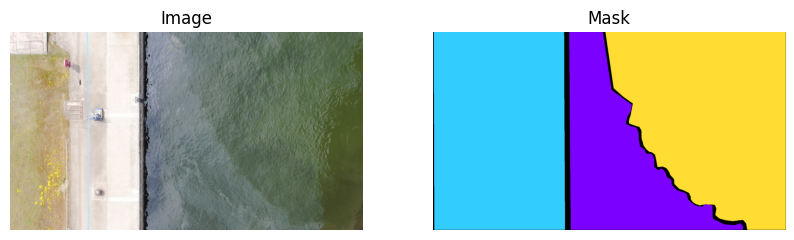

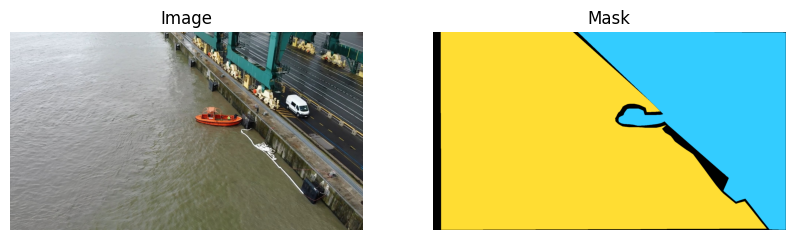

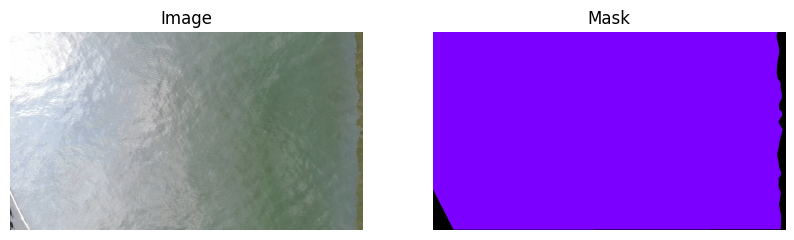

In [ ]:
import cv2
import matplotlib.pyplot as plt
import random

def show_pair(img_path, mask_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(img); plt.title("Image"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(mask); plt.title("Mask"); plt.axis("off")
    plt.show()

for _ in range(3):
    p = random.choice(pairs)
    show_pair(*p)


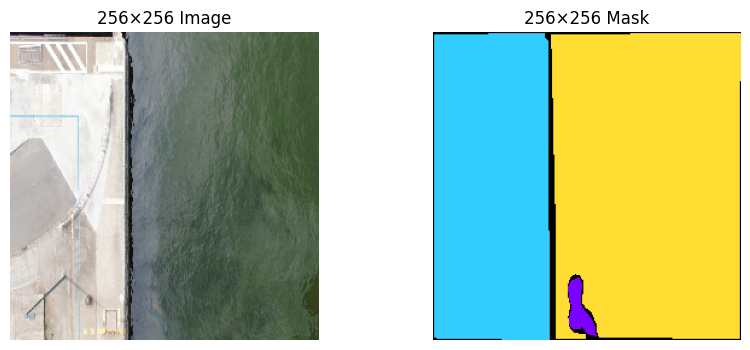

Before normalization: 0–255
After normalization: 0.01568627450980392 1.0


In [ ]:
import numpy as np

TARGET = (256,256)

def preprocess(img_path, mask_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

    img_r = cv2.resize(img, TARGET)
    mask_r = cv2.resize(mask, TARGET, interpolation=cv2.INTER_NEAREST)

    img_norm = img_r / 255.0

    return img_norm, mask_r

img_n, mask_n = preprocess(*pairs[0])

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(img_n); plt.title("256×256 Image"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(mask_n, cmap="gray"); plt.title("256×256 Mask"); plt.axis("off")
plt.show()

print("Before normalization: 0–255")
print("After normalization:", img_n.min(), img_n.max())


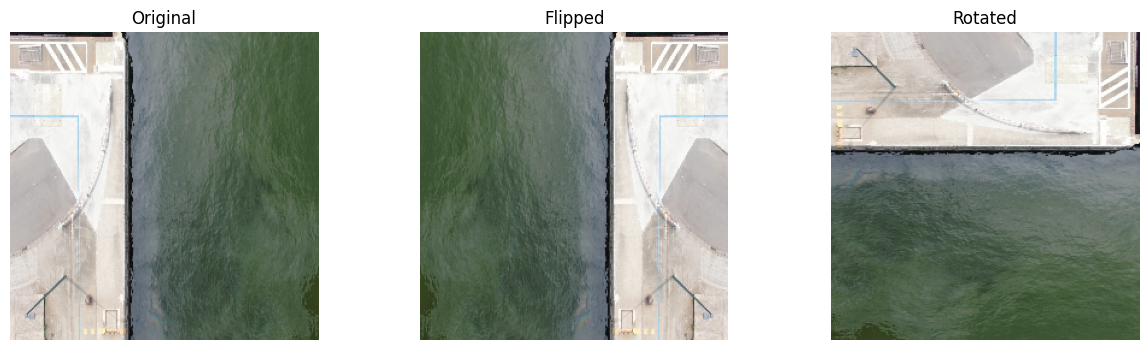

In [ ]:
def augment(img, mask):
    img_u8 = (img * 255).astype(np.uint8)

    flip_img = cv2.flip(img_u8, 1)
    flip_mask = cv2.flip(mask, 1)

    rot_img = cv2.rotate(img_u8, cv2.ROTATE_90_CLOCKWISE)
    rot_mask = cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE)

    return flip_img/255.0, flip_mask, rot_img/255.0, rot_mask

flip, flip_m, rot, rot_m = augment(img_n, mask_n)

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(img_n); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(flip); plt.title("Flipped"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(rot); plt.title("Rotated"); plt.axis("off")
plt.show()


In [ ]:
def generator(data_pairs, batch=4):
    import random
    random.shuffle(data_pairs)

    while True:
        imgs, masks = [], []
        for i in range(batch):
            img, mask = preprocess(*random.choice(data_pairs))
            imgs.append(img)
            masks.append(mask)
        yield np.array(imgs), np.array(masks)

g = generator(pairs, 4)
X, Y = next(g)
print(X.shape, Y.shape)


(4, 256, 256, 3) (4, 256, 256, 3)
